In [ ]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.8 MB/s eta 0:00:00


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1abOH_th3RXci7yUrN4TWCKWTjVUTVMKv/view?usp=sharing -O FakeAVCeleb.zip

Downloading...
From (original): https://drive.google.com/uc?id=1abOH_th3RXci7yUrN4TWCKWTjVUTVMKv
From (redirected): https://drive.google.com/uc?id=1abOH_th3RXci7yUrN4TWCKWTjVUTVMKv&confirm=t&uuid=9b3cbc98-cf82-4d4b-bf48-c15e6752154f
To: /content/FakeAVCeleb.zip
100% 6.40G/6.40G [01:20<00:00, 79.8MB/s]


In [ ]:
!unzip /content/FakeAVCeleb.zip

Показано результат, скорочений до останніх рядків (5000).
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01075_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01216_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01231_XXpYdOHUF-g.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01238_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id02466_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id03556_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id03605_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id03707_pwNcRPQ5qdo.mp4  
  inflating: FakeAVCeleb

In [ ]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter, defaultdict
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np


class B3LSTMClassifier(nn.Module):
    def __init__(self, n_linear_hidden, lstm_hidden_dim, num_lstm_layers,
                 dropout, bidirectional, freeze):
        super(B3LSTMClassifier, self).__init__()

        self.cnn = models.efficientnet_b3()
        self.feature_output_size = 1536

        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-1],
        )

        self.lstm = nn.LSTM(
            input_size=self.feature_output_size,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            dropout=0.1,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * (2 if bidirectional else 1), lstm_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_dim // 2, 1),
        )

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        vid_features = self.feature_extractor(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        lstm_out, _ = self.lstm(vid_features)  # (batch_size, num_frames, lstm_hidden_dim)

        output = self.classifier(lstm_out[:, -1, :])

        return output

In [ ]:
import os
import json
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from facenet_pytorch import MTCNN
import hashlib


class FaceSequenceDataset(Dataset):
    def __init__(self, required_size=20, max_attempt_frames=70, transform=None, device='cuda', cache_dir="cache"):
        self.videos = []
        folders = [os.path.join("/content")]
        with open('celeb_test_set.json') as f:
            videos = json.load(f)
            videos = [(os.path.join(folders[0], video), metadata) for (video, metadata) in videos.items()]
            self.videos += videos
        self.required_size = required_size
        self.max_attempt_frames = max_attempt_frames
        self.transform = transform
        self.device = device
        self.detector = MTCNN(device=self.device, post_process=False)
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def process_frame(self, frame, previous_box):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame_rgb, landmarks=False)
        if boxes is None:
            return None, previous_box

        if previous_box is not None:
            prev_center = np.array([(previous_box[0] + previous_box[2]) / 2,
                                    (previous_box[1] + previous_box[3]) / 2])
            def get_center(box):
                return np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])
            closest_box = min(boxes, key=lambda box: np.linalg.norm(get_center(box) - prev_center))
        else:
            closest_box = boxes[0]

        width = closest_box[2] - closest_box[0]
        height = closest_box[3] - closest_box[1]
        expand_x = width * 0.3 / 2
        expand_y = height * 0.3 / 2
        x1 = max(int(closest_box[0] - expand_x), 0)
        y1 = max(int(closest_box[1] - expand_y), 0)
        x2 = min(int(closest_box[2] + expand_x), frame_rgb.shape[1])
        y2 = min(int(closest_box[3] + expand_y), frame_rgb.shape[0])

        face = frame_rgb[y1:y2, x1:x2]
        face = cv2.resize(face, (224, 224))

        face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0
        return face, closest_box

    def _extract_face_sequence(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        desired_indices = list(np.linspace(0, total_frames - 1, num=self.required_size, dtype=int))

        face_frames = []
        previous_box = None
        current_index = 0

        for target_index in desired_indices:
            while current_index < target_index:
                ret = cap.grab()
                if not ret:
                    break
                current_index += 1

            ret, frame = cap.read()
            if not ret:
                break
            current_index += 1

            face, current_box = self.process_frame(frame, previous_box)
            if face is not None:
                face_frames.append(face)
                previous_box = current_box

        cap.release()

        if len(face_frames) == 0:
            return None

        while len(face_frames) < self.required_size:
            face_frames.append(face_frames[-1])

        face_frames = face_frames[:self.required_size]
        face_frames = torch.stack(face_frames)
        return face_frames

    def _get_cache_file(self, video):
        video_hash = hashlib.sha256(video.encode('utf-8')).hexdigest()
        return os.path.join(self.cache_dir, f"{video_hash}.pt")

    def __getitem__(self, index):
        video, metadata = self.videos[index]
        cache_file = self._get_cache_file(video)

        if os.path.exists(cache_file):
            face_sequence = torch.load(cache_file)
        else:
            face_sequence = self._extract_face_sequence(video)
            if face_sequence is not None:
                torch.save(face_sequence, cache_file)

        if face_sequence is None:
            return None, None
        if self.transform:
            face_sequence = self.transform(face_sequence)
        label = 0.0
        if metadata['label'] == "C":
            label = 1.0
        label_tensor = torch.FloatTensor([label]).to(self.device)
        return face_sequence, label_tensor

    def __len__(self):
        return len(self.videos)

In [ ]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')

    minposs = val_losses.index(min(val_losses))
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [ ]:
class SameAugmentation:
    def __init__(self, augmentations):
        self.augmentations = augmentations

    def __call__(self, frames):
        seed = torch.randint(0, 2**32, (1,)).item()

        augmented_frames = []
        for frame in frames:
            torch.manual_seed(seed)
            augmented_frames.append(self.augmentations(frame))

        return torch.stack(augmented_frames)

In [ ]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv('FakeAVCeleb/meta_data.csv')

df_filtered = df[df['category'].isin(['A', 'C'])]

df_category_c = df_filtered[df_filtered['category'] == 'C']
df_category_c_unique = df_category_c.drop_duplicates(subset=['source']).head(400)

if df_category_c_unique['source'].nunique() < 400:
    raise ValueError("Недостатньо унікальних джерел у категорії 'C'.")

df_category_a = df_filtered[df_filtered['category'] == 'A'].head(400)

df_sampled = pd.concat([df_category_a, df_category_c_unique])

df_unique = df_sampled.groupby(['category', 'race', 'gender']).apply(lambda x: x.drop_duplicates(subset=['source', 'path']).head(50))
df_unique = df_unique.reset_index(drop=True)

df_unique['stratify_col'] = df_unique['category'].astype(str) + '_' + df_unique['race'] + '_' + df_unique['gender']

result = {}
for _, row in df_unique.iterrows():
    s = '/'
    file_path = row['Unnamed: 9'] + s + row['path']
    file_path = file_path.replace('/', '/')

    label = row['category']


    result[file_path] = {
        'label': label
    }


with open('celeb_test_set.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)
df_unique

<ipython-input-9-9a2807edc0a9>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unique = df_sampled.groupby(['category', 'race', 'gender']).apply(lambda x: x.drop_duplicates(subset=['source', 'path']).head(50))


,source,target1,target2,method,category,type,race,gender,path,Unnamed: 9,stratify_col
0,id00076,-,-,real,A,RealVideo-RealAudio,African,men,00109.mp4,FakeAVCeleb/RealVideo-RealAudio/African/men/id...,A_African_men
1,id00166,-,-,real,A,RealVideo-RealAudio,African,men,00010.mp4,FakeAVCeleb/RealVideo-RealAudio/African/men/id...,A_African_men
2,id00173,-,-,real,A,RealVideo-RealAudio,African,men,00118.mp4,FakeAVCeleb/RealVideo-RealAudio/African/men/id...,A_African_men
3,id00366,-,-,real,A,RealVideo-RealAudio,African,men,00118.mp4,FakeAVCeleb/RealVideo-RealAudio/African/men/id...,A_African_men
4,id00391,-,-,real,A,RealVideo-RealAudio,African,men,00052.mp4,FakeAVCeleb/RealVideo-RealAudio/African/men/id...,A_African_men
...,...,...,...,...,...,...,...,...,...,...,...
795,id03716,0.mp4,-,faceswap,C,FakeVideo-RealAudio,Caucasian (European),women,00040_0.mp4,FakeAVCeleb/FakeVideo-RealAudio/Caucasian (Eur...,C_Caucasian (European)_women
796,id03816,id03941,-,faceswap,C,FakeVideo-RealAudio,Caucasian (European),women,00093_id03941_SsYtP8Ze88Q_faceswap.mp4,FakeAVCeleb/FakeVideo-RealAudio/Caucasian (Eur...,C_Caucasian (European)_women
797,id03844,0.mp4,-,faceswap,C,FakeVideo-RealAudio,Caucasian (European),women,00028_0.mp4,FakeAVCeleb/FakeVideo-RealAudio/Caucasian (Eur...,C_Caucasian (European)_women
798,id03858,0.mp4,-,faceswap,C,FakeVideo-RealAudio,Caucasian (European),women,00092_0.mp4,FakeAVCeleb/FakeVideo-RealAudio/Caucasian (Eur...,C_Caucasian (European)_women


In [ ]:
def get_video_info(video_path: str) -> Union[Tuple[int, float], Tuple[None, None]]:
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Не вдалося відкрити файл: {video_path}")
        return None, None

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    return frame_count, fps


video_stats = []

for video_path, label in result.items():
    frame_count, fps = get_video_info(video_path)
    if frame_count is not None and fps is not None:
        video_stats.append({
            'file_path': video_path,
            'label': label['label'],
            'frames': frame_count,
            'fps': fps
        })

df = pd.DataFrame(video_stats)

stats_fps = df['fps'].describe()
stats_frames = df['frames'].describe()

print("FPS статистика:")
print(stats_fps)

print("\nКількість кадрів статистика:")
print(stats_frames)


print("\nКласи статистика:")
print(df['label'].describe())

FPS статистика:
count    1000.000000
mean       25.051627
std         0.522270
min        23.974427
25%        25.000000
50%        25.000000
75%        25.000000
max        30.000000
Name: fps, dtype: float64

Кількість кадрів статистика:
count    1000.000000
mean      163.266000
std        62.091115
min        99.000000
25%       117.000000
50%       144.000000
75%       186.000000
max       442.000000
Name: frames, dtype: float64

Класи статистика:
count     1000
unique       2
top          A
freq       500
Name: label, dtype: object


<Axes: >

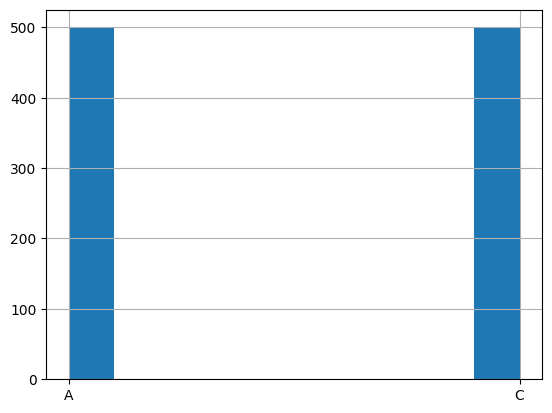

In [ ]:
df['label'].hist()

Test loss: 0.4220, Test accuracy: 0.8275
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81       400
         1.0       0.78      0.90      0.84       400

    accuracy                           0.83       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.83      0.83       800



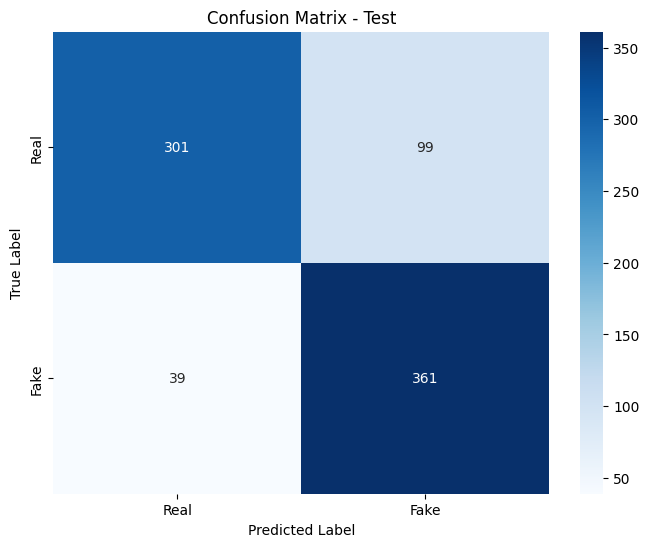

Test AUC: 0.9039468749999999


In [ ]:
from torchvision import transforms
from torch.utils.data._utils.collate import default_collate


def custom_collate(batch):
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return None, None
    return default_collate(batch)


def test_model(model: nn.Module):
    batch_size = 1
    epoch_v_loss = 0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()

    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    )

    test_dataset = FaceSequenceDataset(required_size=20, max_attempt_frames=70, transform=transfor, device='cuda')

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=custom_collate
    )

    model.eval()
    torch.cuda.empty_cache()
    gc.collect()

    all_val_labels, all_val_preds = [], []
    test_probs = []
    with torch.no_grad():
        for video_data, labels in tqdm(test_loader, desc="Test", leave=False):

            if video_data is None and labels is None:
                continue
            video_data, labels = video_data.to(device), labels.to(device)

            output = model(video_data)
            output_probs = torch.sigmoid(output)
            test_probs.extend(output_probs.cpu().numpy())

            loss = criterion(output, labels)
            epoch_v_loss += loss.item()

            output = torch.sigmoid(output).round()

            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(output.cpu().numpy())

    val_loss = epoch_v_loss / len(test_loader)
    val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)

    print(f'Test loss: {val_loss:.4f}, Test accuracy: {val_accuracy:.4f}')

    print("Test Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Test')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Test AUC: {val_auc}')


hyperparameters: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 64,
    'lstm_hidden_dim': 32,
    'num_lstm_layers': 2,
    'dropout': 0.4,
    'bidirectional': False,
    'freeze': False,
    'n_frames': 20,
    'batch_size': 4,
    'lr': 0.00001,
    'num_epochs': 25,
    'gamma': 0.1,
    'milestones': [32, 64]
}

for i in range(1):
    model = ResNetLSTMClassifier(
            n_linear_hidden=hyperparameters['n_linear_hidden'],
            lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
            num_lstm_layers=hyperparameters['num_lstm_layers'],
            bidirectional=hyperparameters['bidirectional'],
            dropout=hyperparameters['dropout'],
            freeze=hyperparameters['freeze']
    )

    model.load_state_dict(torch.load('/content/best_ResNetLSTMNoBiClassifier20x224_lstm_checkpoint_epoch_step_23.pt')['model_state_dict'])
    model.eval()
    test_model(model)